In [1]:
import sentinel_collection as sc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import planetary_computer
import s2_functions
import xarray as xr
import pandas as pd
import geopandas as gpd
import pystac_client
import stackstac
import dask

In [2]:
aoi = gpd.read_file('../../2_data/Koumbia_db/Koumbia_JECAM_2018-20-21.shp')
aoi = aoi.to_crs('EPSG: 4326')
bbox = aoi.total_bounds
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
year = '2018'
time = year + '-01-01/' + year + '-12-31'

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    )

In [4]:
s2_search_all = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox= bbox,
        datetime= time,
        query={'eo:cloud_cover': {"lt": 100}, 
                's2:nodata_pixel_percentage': {'lt': 50},
                's2:mgrs_tile': {'eq': '30PVT'}},
        )

In [5]:
complete_item = s2_search_all.item_collection()

In [6]:
aoi = gpd.read_file('../../2_data/Koumbia_db/Koumbia_JECAM_2018-20-21.shp') # reload data with correct CRS for stackstac clipping
bbox = aoi.total_bounds
stack = stackstac.stack(complete_item, resolution = 10, bounds = bbox, chunksize= (5, 1, 800, 800))

/Users/edgar/opt/anaconda3/envs/GeoDS/lib/python3.11/site-packages/stackstac/accumulate_metadata.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(


In [7]:
stack

<xarray.DataArray 'stackstac-ebbf2cc8f0ee5baea0281b5460ae777a' (time: 69,
                                                                band: 17,
                                                                y: 4513, x: 5183)>
dask.array<fetch_raster_window, shape=(69, 17, 4513, 5183), dtype=float64, chunksize=(5, 1, 800, 800), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
  * band                                     (band) <U7 'AOT' ... 'preview'
  * x                                        (x) float64 4.026e+05 ... 4.544e+05
  * y                                        (y) float64 1.257e+06 ... 1.212e+06
    eo:cloud_cover                           (time) float64 0.004124 ... 14.13
    ...                                       ...
    gsd                                      (band) object 10.0 60.0 ... None
    proj:transform                           (band) object [10.0, 0.0, 399960...
    common_name                              (band) object None ... None
    center_wavelength                        (band) object None 0.443 ... None
    full_width_half_max                      (band) object None 0.027 ... None
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(402570, 1212060, 454400, 1257...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 402570.00|\n| 0.00,-10.00, 1257190.00|\n| 0.0...
    resolution:  10

In [8]:
SCL = stack.sel(band = 'SCL')

In [9]:
cirrus = xr.where(SCL == 10, 1, 0) # cirrus pixels, binary mask 0, 1
highclouds = xr.where(SCL == 9, 1, 0) # High probability clouds, binary mask 0, 1
medclouds = xr.where(SCL == 8, 1, 0) # Medium probability clouds, binary mask 0, 1
unclass = xr.where(SCL == 7, 1, 0) # unclassified pixels, binary mask 0, 1
shaclouds = xr.where(SCL == 3, 1, 0) # Cloud shadows, binary mask 0, 1
saturated = xr.where(SCL == 1, 1, 0) # saturated pixels, binary mask 0, 1

## mannually check quality of final interpolation

mask = highclouds + medclouds + shaclouds + saturated + cirrus + unclass # Mask, binary mask 0, 1

In [10]:
mask

<xarray.DataArray 'stackstac-ebbf2cc8f0ee5baea0281b5460ae777a' (time: 69,
                                                                y: 4513, x: 5183)>
dask.array<add, shape=(69, 4513, 5183), dtype=int64, chunksize=(5, 800, 800), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
    band                                     <U7 'SCL'
  * x                                        (x) float64 4.026e+05 ... 4.544e+05
  * y                                        (y) float64 1.257e+06 ... 1.212e+06
    eo:cloud_cover                           (time) float64 0.004124 ... 14.13
    ...                                       ...
    gsd                                      object 20.0
    proj:transform                           object [20.0, 0.0, 399960.0, 0.0...
    common_name                              object None
    center_wavelength                        object None
    full_width_half_max                      object None
    epsg                                     int64 32630

In [11]:
hcpixels = ((highclouds.sum(axis = (1, 2)) / (highclouds.shape[1] * highclouds.shape[2]))*100).compute()
mcpixels = ((medclouds.sum(axis = (1, 2)) / (highclouds.shape[1] * highclouds.shape[2]))*100).compute()
scpixels = ((shaclouds.sum(axis = (1, 2)) / (highclouds.shape[1] * highclouds.shape[2]))*100).compute()
satpixels = ((saturated.sum(axis = (1, 2)) / (highclouds.shape[1] * highclouds.shape[2]))*100).compute()
cirpixels = ((cirrus.sum(axis = (1, 2)) / (highclouds.shape[1] * highclouds.shape[2]))*100).compute()
ucpixels = ((unclass.sum(axis = (1, 2)) / (highclouds.shape[1] * highclouds.shape[2]))*100).compute()
maskedpixels = ((mask.sum(axis = (1, 2)) / (highclouds.shape[1] * highclouds.shape[2]))*100).compute()

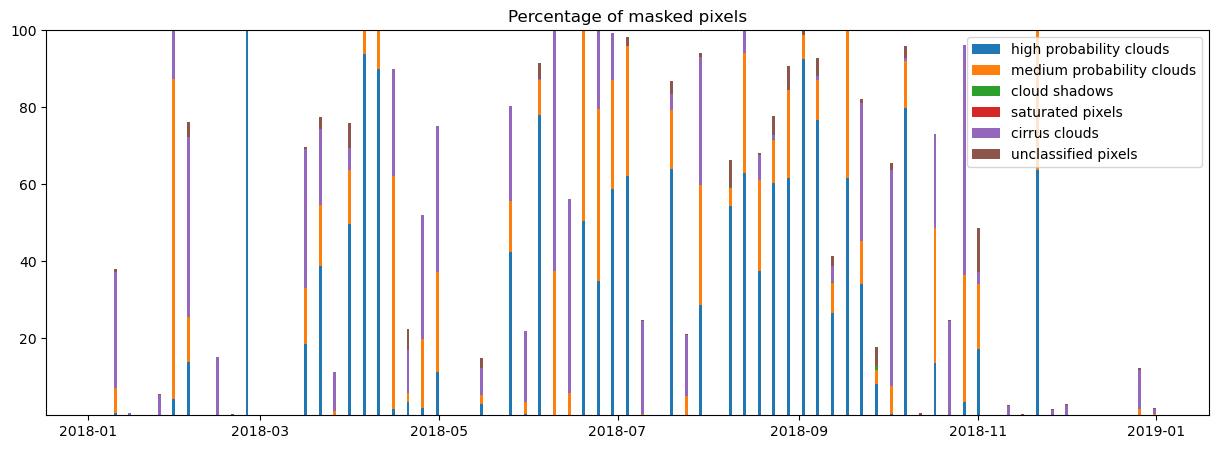

In [12]:
values = {
    'high probability clouds': hcpixels.values,
    'medium probability clouds': mcpixels.values,
    'cloud shadows': scpixels.values,
    'saturated pixels': satpixels.values,
    'cirrus clouds': cirpixels.values,
    'unclassified pixels': ucpixels.values
}

width = 1

fig, ax = plt.subplots(figsize = (15, 5))
bottom = np.zeros(69)

for pixeltype, weight_count in values.items():
    p = ax.bar(hcpixels.indexes['time'], weight_count, width, label=pixeltype, bottom=bottom)
    bottom += weight_count

ax.set_title("Percentage of masked pixels")
ax.legend(loc="upper right")

plt.show()

In [82]:
maskedstack = stack.where(mask == 0, np.nan)

In [83]:
maskedstack

<xarray.DataArray 'stackstac-3352131ba85706873a4e153b2b892893' (time: 69,
                                                                band: 17,
                                                                y: 4513, x: 5183)>
dask.array<where, shape=(69, 17, 4513, 5183), dtype=float64, chunksize=(5, 1, 800, 800), chunktype=numpy.ndarray>
Coordinates: (12/38)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
  * band                                     (band) <U7 'AOT' ... 'preview'
  * x                                        (x) float64 4.026e+05 ... 4.544e+05
  * y                                        (y) float64 1.257e+06 ... 1.212e+06
    s2:reflectance_conversion_factor         (time) float64 1.034 ... 1.034
    ...                                       ...
    s2:unclassified_percentage               (time) float64 0.1308 ... 0.5202
    platform                                 (time) <U11 'Sentinel-2A' ... 'S...
    proj:epsg                                int64 32630
    s2:datatake_id                           (time) <U34 'GS2A_20180105T10342...
    s2:saturated_defective_pixel_percentage  float64 0.0
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(402570, 1212060, 454400, 1257...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 402570.00|\n| 0.00,-10.00, 1257190.00|\n| 0.0...
    resolution:  10

In [84]:
interpolate_stack = maskedstack[:5, :, :, :].interpolate_na(dim="time", method="linear", use_coordinate = 'time')

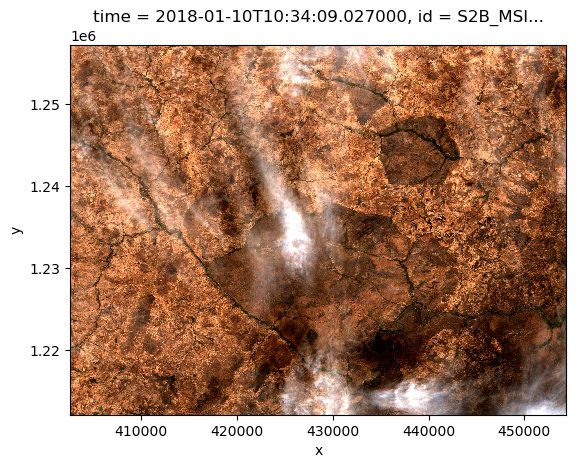

In [35]:
stack[1, :, :, :].sel(band = ['B04', 'B03', 'B02']).plot.imshow(rgb="band", robust=True)

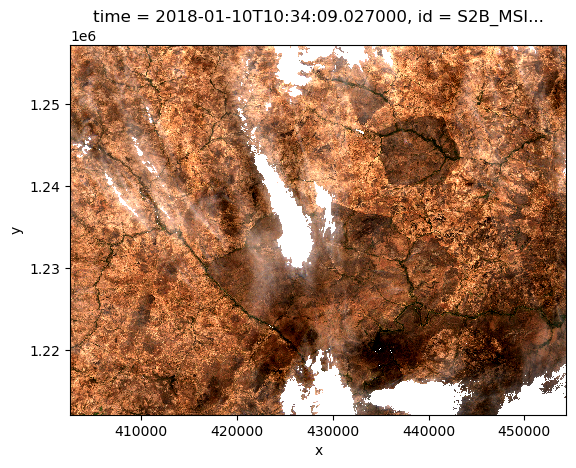

In [26]:
maskedstack[1, :, :, :].sel(band = ['B04', 'B03', 'B02']).plot.imshow(rgb="band", robust=True)

In [42]:
r = maskedstack[:4, :, :, :].sel(band = ['B04']).compute()
g = maskedstack[:4, :, :, :].sel(band = ['B03']).compute()
b = maskedstack[:4, :, :, :].sel(band = ['B02']).compute()

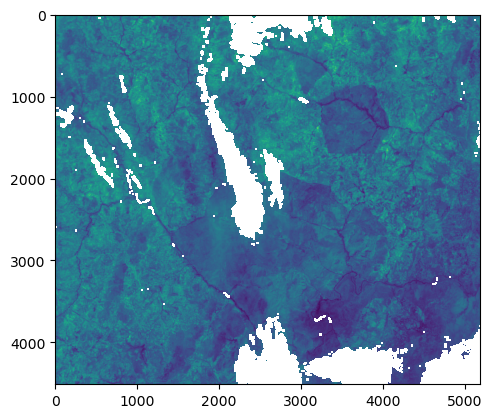

In [43]:
plt.imshow(r[1, :, :, :].squeeze())

In [44]:
r_inter = r.interpolate_na(dim="time", method="linear", use_coordinate = 'time')
g_inter = g.interpolate_na(dim="time", method="linear", use_coordinate = 'time')
b_inter = b.interpolate_na(dim="time", method="linear", use_coordinate = 'time')

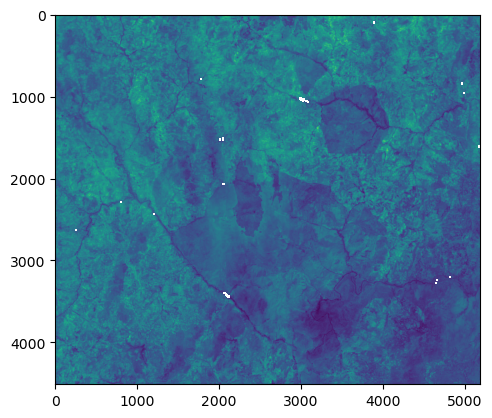

In [45]:
plt.imshow(r_inter[1, :, :, :].squeeze())

In [51]:
rgb = xr.concat([r_inter, g_inter, b_inter], dim = 'band')

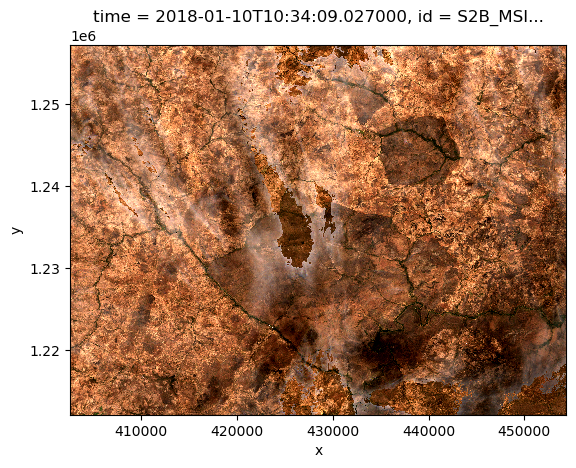

In [53]:
rgb[1, :, :, :].plot.imshow(rgb="band", robust=True)

In [85]:
interpolate_stack

<xarray.DataArray 'stackstac-3352131ba85706873a4e153b2b892893' (time: 5,
                                                                band: 17,
                                                                y: 4513, x: 5183)>
dask.array<transpose, shape=(5, 17, 4513, 5183), dtype=float64, chunksize=(5, 1, 800, 800), chunktype=numpy.ndarray>
Coordinates: (12/38)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
  * band                                     (band) <U7 'AOT' ... 'preview'
  * x                                        (x) float64 4.026e+05 ... 4.544e+05
  * y                                        (y) float64 1.257e+06 ... 1.212e+06
    s2:reflectance_conversion_factor         (time) float64 1.034 ... 1.033
    ...                                       ...
    s2:unclassified_percentage               (time) float64 0.1308 ... 0.1857
    platform                                 (time) <U11 'Sentinel-2A' ... 'S...
    proj:epsg                                int64 32630
    s2:datatake_id                           (time) <U34 'GS2A_20180105T10342...
    s2:saturated_defective_pixel_percentage  float64 0.0
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(402570, 1212060, 454400, 1257...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 402570.00|\n| 0.00,-10.00, 1257190.00|\n| 0.0...
    resolution:  10

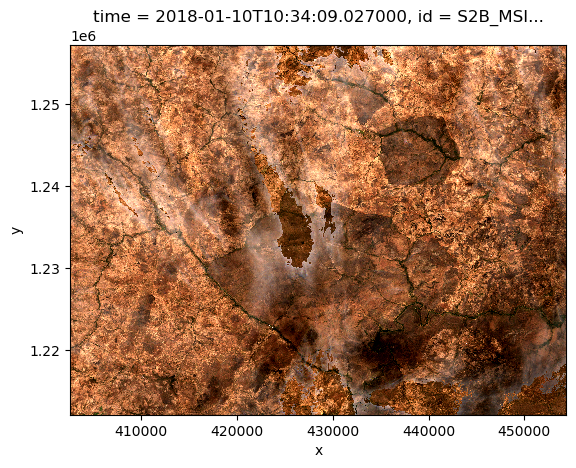

In [86]:
interpolate_stack[1, :, :, :].sel(band = ['B04', 'B03', 'B02']).plot.imshow(rgb="band", robust=True)

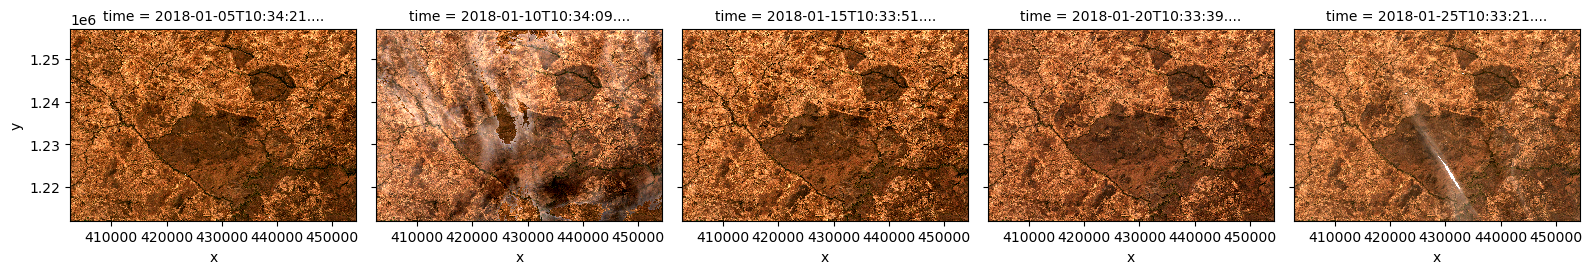

In [87]:
interpolate_stack.sel(band = ['B04', 'B03', 'B02']).plot.imshow(rgb="band", col="time", col_wrap=5, robust=True)

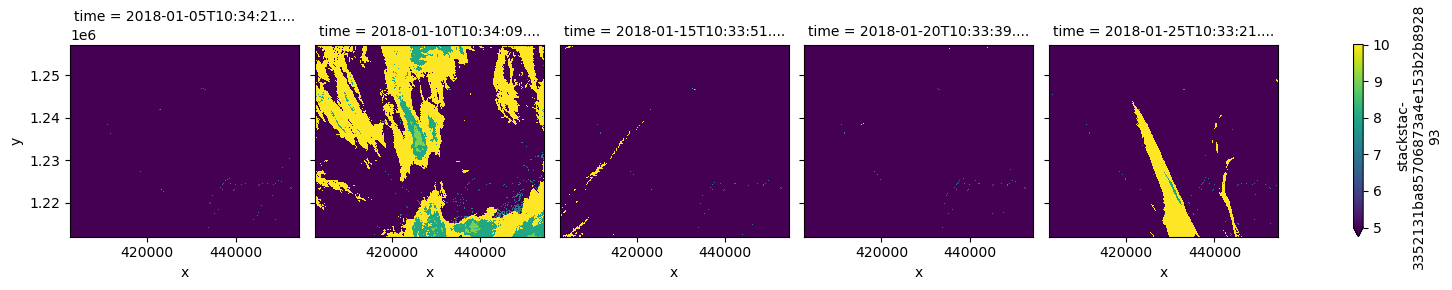

In [89]:
SCL[:5, :, :].plot.imshow(col="time", col_wrap=5, robust=True)

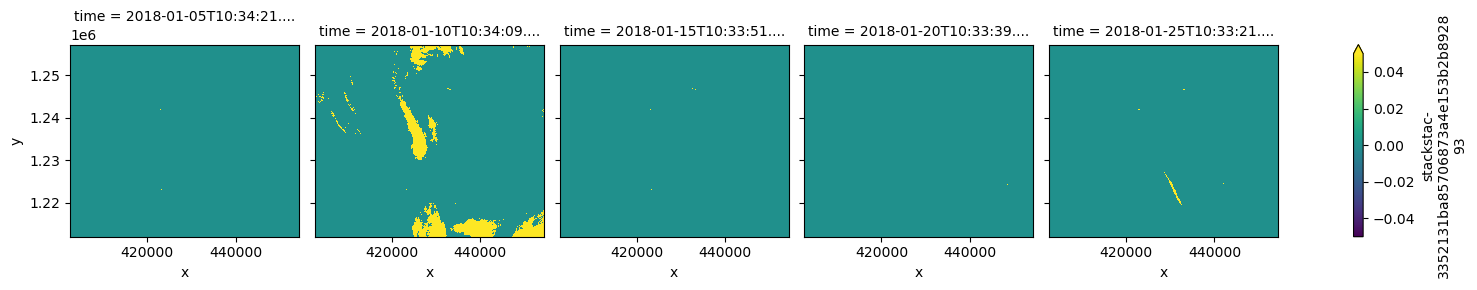

In [90]:
mask[:5, :, :].plot.imshow(col="time", col_wrap=5, robust=True)